Importing modules

In [13]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import skimage.io as ski
import os
import pandas as pd

In [14]:
import numpy as np
import matplotlib.pyplot as plt


In [15]:
tf.config.list_physical_devices()
# tf.device('/device:GPU:0')
# tf.test.is_built_with_cuda()
# tf.test.gpu_device_name()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

Loading the Dataframes

In [16]:
train_df1= pd.read_csv("train.csv")
test_df=pd.read_csv("test.csv")

<h3>Data Augmentation.</h3>
I generated more train images using augmentation to avoid over fitting.


In [6]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
# Generate and save augmented images
for i,row in train_df1.iterrows():
    image=load_img(f'train/train/{row["id"]}')
    image = img_to_array(image)[:,:256,:3]
    image = image.reshape((1,) + image.shape)
    num_augmented_images = 0
    j=0
    for batch in datagen.flow(image, batch_size=1,save_to_dir="train_augmented", save_prefix='', save_format='png'):
        j+=1
        num_augmented_images += 1
        tf.keras.preprocessing.image.save_img(f"train_augmented/{row['id'].split('.')[0]}_{j}.png", batch[0])
        if j >= 4:  # Generate 4 augmented images per input image
            break
print(f"Augmented {num_augmented_images} images.")

<h3>Loading/Reading Augmented Images</h3>


In [17]:
aug_train_df=pd.DataFrame({})
for i in range(4):
    temp=train_df1.copy()
    temp['id']=train_df1['id'].apply(lambda x: x.split('.')[0]+f"_{i}.png")  #creating dataframe for augmented data images.
    aug_train_df=pd.concat([aug_train_df,temp])

In [18]:
#Split the data into training and validation dataset
train_df, val_df= train_test_split(aug_train_df, test_size=0.2, random_state=0)

In [19]:
aug_train_df

,id,binary_pred,segmentation_pred
0,Img_0_0.png,1,12230 2 12485 3 12740 5 12764 6 12996 5 13019 ...
1,Img_1_0.png,1,24677 5 24933 7 25188 10 25443 13 25699 14 259...
2,Img_2_0.png,0,Healthy
3,Img_3_0.png,1,117 1 373 29 628 30 884 30 1141 29 1397 29 165...
4,Img_4_0.png,1,1 3 20 25 257 4 277 24 382 8 513 5 534 23 636 ...
...,...,...,...
914,Img_914_3.png,1,19320 3 19577 6 19833 6 20089 5 20098 5 20347 ...
915,Img_915_3.png,1,2145 2 2401 2 2657 4 2913 8 3170 9 3426 10 368...
916,Img_916_3.png,1,19595 28 19849 38 20104 46 20358 55 20612 62 2...
917,Img_917_3.png,0,Healthy


In [21]:
#load/read images
train_data=[]
val_data=[]
for i,row in train_df.iterrows():
    try:
        image=ski.imread(f'train_augmented/{row["id"]}')[:,:256,:3]
        image=image/255
        train_data.append((image,row['binary_pred']))
    except:
        pass
for i,row in val_df.iterrows():
    try:
        image=ski.imread(f'train_augmented/{row["id"]}')[:,:256,:3]
        image=image/255
        val_data.append((image,row['binary_pred']))
    except:
        pass


In [22]:
train_data=np.array(train_data)
val_data=np.array(val_data)

train_dataset = tf.data.Dataset.from_tensor_slices((train_data[:,:1].reshape(len(train_data)).tolist(), train_data[:,1:].reshape(len(train_data)).tolist()))
val_dataset = tf.data.Dataset.from_tensor_slices((val_data[:,:1].reshape(len(val_data)).tolist(), val_data[:,1:].reshape(len(val_data)).tolist()))

/apps/codes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.
/apps/codes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [23]:
BATCH_SIZE = 16
train_dataset = train_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

In [24]:
train_data.take(0).shape

(256, 256, 3)

<h3>Model</h3>
The below is the model. I used pre-trained ResNet50v2 model and finetuned the last 5 layers


In [57]:
def ResNet50V2_model(input_shape, optimizer='rmsprop', finetune_layers=0):
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    pre_trained_model = tf.keras.applications.ResNet50V2(include_top=False,
                     weights="imagenet",pooling='avg',
                     input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable depending on the size of the fine-tuning parameter.
    if finetune_layers > 0:
        for layer in pre_trained_model.layers[:-finetune_layers]:
            layer.trainable = False
    else:
        for layer in pre_trained_model.layers:
            layer.trainable = False

    model= tf.keras.Sequential()
    model.add(pre_trained_model)
    model.add(tf.keras.layers.Flatten(name="flatten"))
    model.add(tf.keras.layers.Dense(512, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model
model=ResNet50V2_model(input_shape=(256, 256, 3),optimizer=Adam(learning_rate=0.0001),finetune_layers=5)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 513       
                                                                 
Total params: 24,614,401
Trainable params: 2,104,321
Non-trainable params: 22,510,080
_________________________________________________________________


In [26]:
# model = tf.keras.Sequential()
# model.add(tf.keras.layers.Conv2D(32, (3, 3), input_shape=(256, 256, 3)))
# model.add(tf.keras.layers.Activation('relu'))
# model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# model.add(tf.keras.layers.Conv2D(64, (3, 3)))
# model.add(tf.keras.layers.Activation('relu'))
# model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# model.add(tf.keras.layers.Conv2D(128, (3, 3)))
# model.add(tf.keras.layers.Activation('relu'))
# model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# model.add(tf.keras.layers.Conv2D(256, (3, 3)))
# model.add(tf.keras.layers.Activation('relu'))
# model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.Dense(64))
# model.add(tf.keras.layers.Activation('relu'))
# model.add(tf.keras.layers.Dropout(0.5))
# model.add(tf.keras.layers.Dense(1))
# model.add(tf.keras.layers.Activation('sigmoid'))
# model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.001),metrics=['accuracy'])
# model.summary()

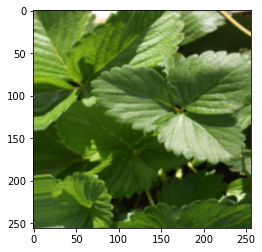

In [28]:
plt.imshow(train_data.take(100))

<h3>Training the model</h3>


In [58]:
#Train the model
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0.001,
                                            patience=3,
                                            restore_best_weights=False)
history =model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=15,
    callbacks=callback,
    batch_size=16,)

Epoch 1/15
139/139 [==============================] - 70s 485ms/step - loss: 0.2661 - accuracy: 0.8900 - val_loss: 0.2058 - val_accuracy: 0.9196
Epoch 2/15
139/139 [==============================] - 66s 474ms/step - loss: 0.1111 - accuracy: 0.9594 - val_loss: 0.1362 - val_accuracy: 0.9607
Epoch 3/15
139/139 [==============================] - 65s 470ms/step - loss: 0.0550 - accuracy: 0.9851 - val_loss: 0.0934 - val_accuracy: 0.9645
Epoch 4/15
139/139 [==============================] - 66s 475ms/step - loss: 0.0251 - accuracy: 0.9982 - val_loss: 0.0851 - val_accuracy: 0.9701
Epoch 5/15
139/139 [==============================] - 65s 470ms/step - loss: 0.0127 - accuracy: 1.0000 - val_loss: 0.0833 - val_accuracy: 0.9720
Epoch 6/15
139/139 [==============================] - 66s 475ms/step - loss: 0.0076 - accuracy: 1.0000 - val_loss: 0.0843 - val_accuracy: 0.9738
Epoch 7/15
139/139 [==============================] - 65s 470ms/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.0862 - val_ac

<h3>Save the model</h3>


In [59]:
model.save("resnet_model.h5")
# model = tf.keras.models.load_model('unet_model.h5')

<h3>Training Performence plots</h3>


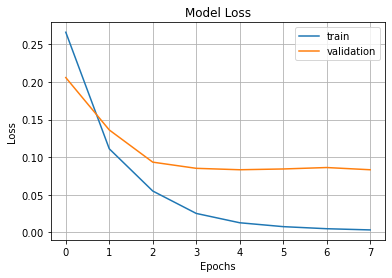

In [60]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

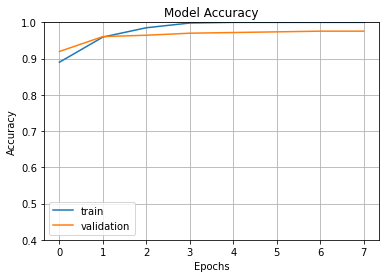

In [61]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()
     

<h3>Loading the test data and predicting the classes</h3>



In [38]:
test_df=pd.read_csv("test.csv")
test_data=[]
for i,row in test_df.iterrows():
    image=ski.imread(f'test/test/{row["id"]}')[:,:256,:3]
    image=image/255
    test_data.append(image)

In [39]:
test_data=np.expand_dims(test_data, axis=0)
test_dataset = tf.data.Dataset.from_tensor_slices(test_data)

In [62]:
predictions=model.predict(test_dataset)
predictions=tf.round(predictions)

1/1 [==============================] - 5s 5s/step


In [63]:
pre_list=predictions.numpy().reshape(len(predictions))
pre_list

array([0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1.,
       1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1.,
       0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1.,
       1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1.,
       0., 1., 0., 1., 0.

Save predictions to file

In [65]:
submisssion= pd.read_csv("sample_submission.csv")

In [66]:
submisssion['binary_pred']=pre_list

In [67]:
submisssion.to_csv('sample_submission.csv',index=False)

In [55]:
# from numba import cuda 
# device = cuda.get_current_device()
# device.reset()
# test_df


<h3>End</h3>
